In [ ]:
# Designed for MLH Data Day Grind Hackathon
# Webcred.tech
# Use NLP to detect fake job listings

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
import csv
import os

labels = []
textFeatures = []

with open('/content/fake_job_postings.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    feature = []
    # job title, department name, company name, description, requirements
    textFeatures.append(str(row[1]) + " " + str(row[3]) + " " + str(row[5]) + " " + str(row[6]) + " " + str(row[7]))

    # define for categorical crossentropy
    itemLabel = [0,0]
    itemLabel[int(row[-1])] = 1
    labels.append(itemLabel)




In [ ]:
# split data into training and validation sets
splitProp = .7
splitIndex = round(len(textFeatures) * splitProp)

allText = textFeatures
allLabels = labels

trainingText = allText[:splitIndex]
validationText = allText[splitIndex:]
trainingLabels = allLabels[:splitIndex]
validationLabels = allLabels[splitIndex:]

In [ ]:
# preview text format
print(np.array(allText))

["Marketing Intern Marketing We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winning online food community and crowd-sou

In [ ]:
vocab_size = 1000
embedding_dim = 24
max_length = 100
trunc_type='post'
oov_tok='<OOV>'

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#tokenize and pad data
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(trainingText)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(trainingText)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(validationText)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, truncating=trunc_type)

In [ ]:
#padded token matrix
print(testing_padded[20])

#original text
print(validationText[20])

[  1   1   1   1   1 314 439 355 395 314 440  54   3  71  13   1   4   1
 685   3 535   4 947 145   9  29  72  12  75  71 225  29 314   1   2   1
  29 588 100  26   1   1   7   1   1   1  11  51   9   6 321   2 376   1
   1  37 285  87  17 112   3   1   1   2   1 378   1 148 103  87  17 683
   3 583   1   7   1   1   2   1  12 300 147   1   1   2 312  11 697  26
  87  17 112   3   1   1  42   1   1 378]
TV Satellite Dish Installer  Hawkeye Recruitment provides cost effective recruitment advertising solutions to help you cast the widest net to find the perfect candidate for your job. We can help improve your recruitment efforts, and streamline your hiring process.  Holaday Satellite in Mount Pleasant Iowa is looking for a motivated and experienced Satellite Installer. This individual must be able to install Dish and Directv without supervision. They also must be willing to become certified in installing DishNet and Exede. We offer excellent wages. Van and equipment is provided.  Must be

In [ ]:
# Network Structure
# Embedding Layer maps tokenized words to nth dimensional vector (allows words to be respresented as a position in space)
# 2 Bidirectional LSTM layers (allows words to be a factor using cell states)
# 3 Dense Layers Simple DNN and Output


#create model structure
layers = [tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
          tf.keras.layers.Dense(512, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(2, activation='softmax')]

# create model and compile
model = tf.keras.models.Sequential(layers)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=.0005), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 24)           24000     
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 64)           14592     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 171,714
Trainable params: 171,714
Non-trainable params: 0
__________________________________________________

In [ ]:
history = model.fit(padded, np.array(trainingLabels), epochs=1, validation_data=(testing_padded, np.array(validationLabels)))

392/392 [==============================] - 41s 103ms/step - loss: 0.0495 - accuracy: 0.9847 - val_loss: 0.1115 - val_accuracy: 0.9627


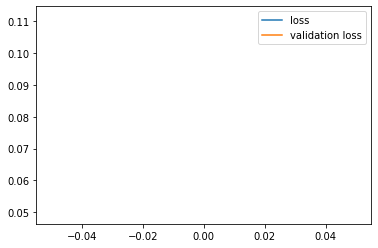

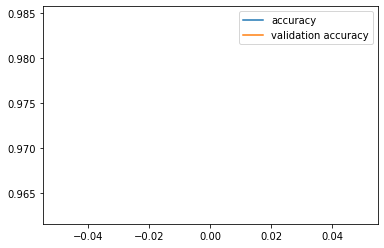

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = list(range(len(loss)))

plt.figure(1)
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.legend()
plt.figure(2)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.legend()
plt.show()


In [ ]:
sequence = tokenizer.texts_to_sequences(["This job requires you to work for free."])
paddedSeq = pad_sequences(sequence, maxlen=max_length, truncating=trunc_type)

out = model.predict(paddedSeq)[0]
prob = 0
if out[0] >= .5:
  print("Not a Scam")
  prob = out[0]
else:
  print("Scam")
  prob = out[1]

print("with {prob}% confidence".format(prob = prob*100))


Not a Scam
with 56.72293305397034% confidence


In [ ]:
print(word_index)

{'<OOV>': 1, 'and': 2, 'to': 3, 'the': 4, 'of': 5, 'a': 6, 'in': 7, 'with': 8, 'for': 9, 'our': 10, 'is': 11, 'we': 12, 'you': 13, 'are': 14, 'as': 15, 'on': 16, 'be': 17, 'experience': 18, 'or': 19, 'work': 20, 'that': 21, 'team': 22, 'will': 23, 'an': 24, 'have': 25, '\xa0': 26, 'business': 27, 'all': 28, 'your': 29, 'at': 30, 'skills': 31, 'customer': 32, 'company': 33, 'by': 34, 'management': 35, 'new': 36, 'this': 37, 'their': 38, 'from': 39, 'sales': 40, 'development': 41, 'amp': 42, 'services': 43, 'service': 44, 'working': 45, 'it': 46, 'time': 47, 'marketing': 48, 'years': 49, 'design': 50, 'looking': 51, 'product': 52, 'ability': 53, 'solutions': 54, 'people': 55, 'us': 56, 'other': 57, 'who': 58, 'knowledge': 59, 'data': 60, 'not': 61, 'software': 62, 'technology': 63, 'support': 64, 'clients': 65, 'web': 66, 'up': 67, 'required': 68, 'more': 69, 'url': 70, 'help': 71, 'job': 72, 'high': 73, 'communication': 74, 'can': 75, 'including': 76, 'about': 77, 'based': 78, 'customer

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

import io

inv_tokenizer = {v: k for k, v in word_index.items()}

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = inv_tokenizer.get(word_num)
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()
print(file_len('vecs.tsv'), file_len('meta.tsv'))

try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

(1000, 24)
999 999


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle as pkl

# export model and tokenizer
model.save('/content/jobModel.h5')
pkl.dump(tokenizer, open('/content/jobTokenizer.pkl', 'wb'))